In [1]:
###### Routine for extraccting braided channel centerlines from binary water mask

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Point
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append("/Volumes/OneTouch/work/scripts")
import proc as pc
import xarray as xr
import netCDF4 as nc 

# For skeleton pruning
from skimage.morphology import skeletonize, binary_dilation, binary_erosion, label, remove_small_holes
from skimage.filters import gaussian
from scipy.signal import convolve2d
from scipy.spatial import cKDTree

# Importing centerlines and converting between image coordinates and lat lon
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
from rasterio.transform import from_origin


# Computing slopes
from sklearn.linear_model import LinearRegression

# Plotting
import matplotlib.lines as mlines



In [2]:
############# Skeleton pruning functions
def find_joints(skeleton):
    # (do not count the center pixel)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    neighbor_count = convolve2d(skeleton.astype(int), kernel, mode='same')
    jointpoints = (neighbor_count > 2) & (skeleton.astype(int) == 1)
    joints_removed_mask = (skeleton.astype(int) == 1) & (neighbor_count <= 2)

    return jointpoints, joints_removed_mask

def find_endpoints(skeleton):
    # (do not count the center pixel)
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])

    neighbor_count = convolve2d(skeleton.astype(int), kernel, mode='same')
    endpoints = (neighbor_count == 1) & (skeleton.astype(int) == 1)

    return endpoints


def trace_branch(skeleton, start_y, start_x):
    # Trace branch from a joint to the endpoint
    # OLD FUNCTION
    visited = set()
    stack = [(start_y, start_x)]
    branch = []
    
    while stack:
        y, x = stack.pop()
        if (y, x) in visited:
            continue
        visited.add((y, x))
        branch.append((y, x))
        
        # Check if the current point is an endpoint
        if endpoints[y, x]:
            break

        # Check 8-connected neighbors
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1] and skeleton[ny, nx] and (ny, nx) not in visited:
                stack.append((ny, nx))
                
    return branch


def trace_branch_from_endpoint(endpoint,joint_coords,pruned_skeleton):
    # Function to trace branch starting from an endpoint

    branch_pixels = [endpoint]
    visited = set(branch_pixels)
    current_pixel = endpoint

    while True:
        neighbors = [(current_pixel[0] + i, current_pixel[1] + j) 
                    for i in [-1, 0, 1] for j in [-1, 0, 1] 
                    if not (i == 0 and j == 0)]
        
            
        next_pixels = [p for p in neighbors if pruned_skeleton[p] == 1 and p not in visited]
            
        if not next_pixels:
            break
            
        # Check if we have reached a joint
        joint_coords_set = {tuple(coord) for coord in joint_coords}
        if any(pixel in joint_coords_set for pixel in next_pixels):
            #print('Pixel is a joint!')
            break
        
        current_pixel = next_pixels[0]
        branch_pixels.append(current_pixel)
        visited.add(current_pixel)

    return branch_pixels
    

def compute_branchlen(endpoint,joint_coords,pruned_skeleton):
    distances = np.sqrt((joint_coords[:, 0] - endpoint[0])**2 + (joint_coords[:, 1] - endpoint[1])**2)
    # Find the minimum distance
    min_distance = np.min(distances) # in pixels
    return(min_distance)


def prune_branches(skeleton, length_threshold):
    # Function for pruning branches
    endpoints = find_endpoints(skeleton)
    joints, joints_removed_mask = find_joints(skeleton)
    joint_coords = np.where(joints == 1)  # Get skeleton coordinates
    joint_coords = np.dstack((joint_coords[0],joint_coords[1]))
    joint_coords = joint_coords.reshape(-1, 2)
    pruned_skeleton = skeleton.copy()

    # Iterate over all endpoints and trace branches
    for i in range(len(np.where(endpoints)[0])):
        endpoint = (np.where(endpoints)[0][i], np.where(endpoints)[1][i]) # y, x
        
        # If endpoint crosses frame exit, keep branch (FOR N-S traveling rivers..need to add option for E-W rivers)
        if endpoint[0] == np.min(np.where(endpoints)[0]) or endpoint[0] == np.max(np.where(endpoints)[0]):
            continue

        # Only select branches to search over that are less than a threshold length
        branchlen = compute_branchlen(endpoint, joint_coords, pruned_skeleton)
        if branchlen < length_threshold:
            # need to now locate all pixels in this branch and remove them
            branch = trace_branch_from_endpoint(endpoint,joint_coords,pruned_skeleton) #returns branch pixels
            if branch == None:
                print('No pixels in branch!')
                continue
            for pixel in branch:
                pruned_skeleton[pixel] = 0  # Remove branch pixels

    return pruned_skeleton


def add_line(skeleton, start, end):
    # Function to add a straight line of skeleton pixels between two points
    y0, x0 = start
    y1, x1 = end
    length = max(abs(y1 - y0), abs(x1 - x0)) + 1
    y_values = np.linspace(y0, y1, length).round().astype(int)
    x_values = np.linspace(x0, x1, length).round().astype(int)
    skeleton[y_values, x_values] = 1
    return skeleton

def connect_close_endpoints(skeleton, distance_threshold=10):
    # Connect close endpoints
    endpoints = find_endpoints(skeleton)
    endpoint_coords = np.column_stack(np.where(endpoints))
    
    if len(endpoint_coords) < 2:
        return skeleton  # No connections possible with fewer than 2 endpoints

    # Use KDTree to find endpoint pairs within the distance threshold
    tree = cKDTree(endpoint_coords)
    pairs = tree.query_pairs(distance_threshold)
    
    for (idx1, idx2) in pairs:
        point1 = tuple(endpoint_coords[idx1])
        point2 = tuple(endpoint_coords[idx2])
        skeleton = add_line(skeleton, point1, point2)

    return skeleton

def fill_small_holes(skeleton, max_hole_size=3):
    # Close small gaps in the skeleton to fill tiny loops
    filled_skeleton = remove_small_holes(skeleton, area_threshold=max_hole_size**2)

    # Fill small holes specifically up to max_hole_size (in pixels)    
    return filled_skeleton.astype(int)



def createKernel(radius):
    # create circular kernel
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    return kernel



def trace_branch_and_label(startpoint, initial_joint, joint_coords, pruned_skeleton, labeled_segments, assign_id, visited_segments):
    # This function for tracing !ONE! branch from the starting joint until it reaches a joint or end point
    # The pixel 'startpoint' is one of the neighbors of the initial joint
    # The list 'initial_joint' prevents the branch from going in the direction of the initial joint
    branch_pixels = [startpoint]
    visited = set(branch_pixels)
    initial_joint = set([initial_joint])
    current_pixel = startpoint
    joint_coords_set = {tuple(coord) for coord in joint_coords}

    while True:
        neighbors = [(current_pixel[0] + i, current_pixel[1] + j) 
                    for i in [-1, 0, 1] for j in [-1, 0, 1] 
                    if not (i == 0 and j == 0)]
        
        next_pixels = [p for p in neighbors if pruned_skeleton[p] == 1 and p not in visited and p not in initial_joint]
        
        if not next_pixels:
            break


        if any(pixel in joint_coords_set for pixel in next_pixels):
            break

        current_pixel = next_pixels[0]     # Should just be one next pixel if not a joint
        branch_pixels.append(current_pixel)
        visited.add(current_pixel)

    for pixel in branch_pixels:
        labeled_segments[pixel] = assign_id
        visited_segments.add(pixel)         # Mark as processed

    return labeled_segments, visited_segments


def assign_unique_ids_to_branches(pruned_skeleton, joint_coords, starting_pixel=None):
    ### Wrapper function to assign unique IDs to all branches
    #  -- Starting pixel should be the northern most jointpoint (if provided)
    #  -- Joint_coords are sorted by y index (smallest first)
    #  RETURNS:
    # updated_labeled_segments: a numpy array same size as pruned skeleton with unique branch IDs for branches between joints

    labeled_segments = np.zeros_like(pruned_skeleton,dtype=int)
    assign_id = 1 
    visited_pixels = set()
    
    # If a specific starting pixel (northern most jointpoint) is provided, trace from it first
    if starting_pixel:
        labeled_segments = trace_branch_and_label(starting_pixel, starting_pixel, joint_coords, pruned_skeleton, labeled_segments, assign_id, visited_pixels)
        assign_id += 1
        # Remove starting pixel from joint coordinates to avoid re-tracing
        joint_coords = [coord for coord in joint_coords if tuple(coord) != tuple(starting_pixel)]


    # Iterate over joints to trace branches between joints
    for joint in joint_coords:
        neighbors = [(joint[0] + i, joint[1] + j)
                     for i in [-1, 0, 1] for j in [-1, 0, 1]
                     if not (i == 0 and j == 0)]
        
        branch_lengths = []
        branch_ids = []
        initial_joint = (joint[0],joint[1])
        
        
        for neighbor in neighbors:
            if pruned_skeleton[neighbor] == 1 and neighbor not in visited_pixels:
                # Trace the branch starting from this neighbor
                current_label_segments = np.copy(labeled_segments)
                current_label_segments, visited_pixels = trace_branch_and_label(neighbor, initial_joint, joint_coords, pruned_skeleton, current_label_segments, assign_id, visited_pixels)
                
                # Calculate branch length (for assignment of the joint pixel)
                branch_length = np.sum(current_label_segments == assign_id)
                if branch_length > 1:  # Proceed only if branch contains more than one pixel
                    branch_lengths.append(branch_length)
                    branch_ids.append(assign_id)
                    # Assign unique ID for each traced branch
                    labeled_segments = np.where(current_label_segments == assign_id, assign_id, labeled_segments)
                    assign_id += 1

            # Find longest branch connected to the joint and assign its ID to the joint pixel
            if branch_lengths:
                longest_branch_id = branch_ids[np.argmax(branch_lengths)]
                labeled_segments[joint[0], joint[1]] = longest_branch_id # Set joint ID to the ID of the longest connected branch
                visited_pixels.add((joint[0], joint[1]))


    # Assign ID to redundant joint pixels (branch len == 1)
    joint_coords_redundant = np.column_stack(np.where((pruned_skeleton == 1) & (labeled_segments == 0)))

    if len(joint_coords_redundant) > 0:
        labeled_coords = np.column_stack(np.where(labeled_segments > 0))
        branch_ids = labeled_segments[labeled_coords[:, 0], labeled_coords[:, 1]]
        branch_tree = cKDTree(labeled_coords)
        updated_labeled_segments = labeled_segments.copy()

        for joint in joint_coords_redundant:
            distance, nearest_index = branch_tree.query(joint)
            nearest_branch_pixel = labeled_coords[nearest_index]
            nearest_branch_id = labeled_segments[tuple(nearest_branch_pixel)]
            updated_labeled_segments[tuple(joint)] = nearest_branch_id
    else:
        updated_labeled_segments = labeled_segments.copy()


    return updated_labeled_segments

def extract_latlon_with_branch_id(geotiff_path, labeled_skeleton):
    ## OLD
    #### Failure to properly sort cl... pc.order_cl not yet working.

    #####  -- Converts pixel coordinates of labeled skeleton mask with branch IDs to latitude and longitude, and returns them in a pandas DataFrame.
    # INPUTS:
    # - geotiff_path: Path to the GeoTIFF file.
    # - labeled_skeleton: numpy array with labeled branches where each non-zero pixel represents a branch ID.
    #  -- Initialize an array to hold labeled segments
    # RETURNS:
    # - df: pandas DataFrame with columns ['latitude', 'longitude', 'branch_id']
    # - gdf: GeoDataFrame with columns ['branch_id', 'geometry'], where geometry contains LineStrings

    # Get the coordinates and branch IDs from labeled skeleton
    rows, cols = np.where(labeled_skeleton > 0) # rows == y, cols == x
    branch_ids = labeled_skeleton[rows, cols]
    pixel_coords = np.column_stack((rows, cols))

    with rasterio.open(geotiff_path) as dataset:
        latlon_coords = np.array([dataset.xy(row, col) for row, col in pixel_coords])

    df = pd.DataFrame({
        'latitude': latlon_coords[:, 1],  # latitude is the second item in (x, y) output from dataset.xy
        'longitude': latlon_coords[:, 0], # longitude is the first item in (x, y)
        'branch_id': branch_ids
    })

    line_data = []

    # Group points by branch_id and create a LineString for each group
    for branch_id, group in df.groupby('branch_id'):


        # points = [tuple(x) for x in group[['longitude', 'latitude']].to_numpy()]
        # ORDER POINTS!
        x = [x for x,y in group[['longitude', 'latitude']].to_numpy()]
        y = [y for x,y in group[['longitude', 'latitude']].to_numpy()]


        temp_cl_df = pd.DataFrame({'x':x,'y':y})
        temp_cl_df = pc.order_cl(temp_cl_df, 'lat') # Orders the df
        points = [tuple(x) for x in temp_cl_df[['x', 'y']].to_numpy()]
        print(points)
        
        if len(points) > 1:  # Only create LineString if there are at least two points
            line = LineString(points)
            #reversed_line = LineString(line.coords[::-1])
            line_data.append({'branch_id': branch_id, 'geometry': line})
    
    # Create a GeoDataFrame from the list of LineStrings
    gdf = gpd.GeoDataFrame(line_data, crs="EPSG:4326")  # Assuming WGS84


    return df, gdf


def latlon_to_pixel_coordinates(geotiff_path, latitudes, longitudes):
    # - Function to convert SWORD lat lon cl to image coordinates
    # - Performs the opposite of function extract_latlon_with_branch_id

    with rasterio.open(geotiff_path) as dataset:
        transform = dataset.transform

    # Convert lat/lon to pixel (row, col) using the inverse of the transform
    pixel_coords = [~transform * (lon, lat) for lat, lon in zip(latitudes, longitudes)]
    
    # Convert the result to a pandas df
    pixel_coords_df = pd.DataFrame(pixel_coords, columns=['x', 'y'])


    
    return pixel_coords_df


def trim2mask(pixc_gdf,mask_tiff_filename,figdir,pixcdate):
    # - Function to trim pixel cloud data to a binary mask (numpy array of 1s and 0s)
    # - Water mask generated from S2 optical imagery and imported as a geotiff

    with rasterio.open(mask_tiff_filename) as water_mask:
        water_mask_data= water_mask.read(1)  # Read the first band (binary mask)
        mask_transform = water_mask.transform  # Get the affine transform
        mask_crs = water_mask.crs  # Get the CRS (coordinate reference system)

    if pixc_gdf.crs != mask_crs:
        pixc_gdf = pixc_gdf.to_crs(mask_crs)
    point_coords = [(geom.x, geom.y) for geom in pixc_gdf.geometry]

    # Sample the mask raster at each point
    with rasterio.open(mask_tiff_filename) as src:
        sampled_values = list(src.sample(point_coords))

    sampled_values = np.array([val[0] for val in sampled_values]) #unwrap

    pixc_gdf['water_masked'] = sampled_values == 1 # Sets water_masked to true if sample is 1 in the mask
    trimmed_gdf = pixc_gdf[pixc_gdf['water_masked'] == True]

    # Plot masked results
    pixc_gdf.plot(column='water_masked', markersize=0.1, legend=True,categorical=True,cmap='tab20')
    plt.savefig(figdir+'/pixc_WM_'+str(pixcdate)+'.png')

    return trimmed_gdf, pixc_gdf

def pixel_coordinates2latlonline(geotiff_path, pixel_y, pixel_x,branch_id,reverse=False):
    # - Function to convert image coordinates to latitude and longitude
    # - pixel_y and pixel_x are already sorted as ascending from their endpoint (first entry)
    # - Returns line geometry of the pixel coordinates converted to latitude and longitude

    pixel_coords = np.column_stack((pixel_y, pixel_x))

    with rasterio.open(geotiff_path) as dataset:
        latlon_coords = np.array([dataset.xy(row, col) for row, col in pixel_coords])

    df = pd.DataFrame({
        'latitude': latlon_coords[:, 1],  # latitude is the second item in (x, y) output from dataset.xy
        'longitude': latlon_coords[:, 0], # longitude is the first item in (x, y)
    })

    points = [tuple(x) for x in df[['longitude', 'latitude']].to_numpy()]

    if len(points) > 1:  # Only create LineString if there are at least two points
        line = LineString(points)
        if reverse == True:
            line = LineString(line.coords[::-1])
    if len(points) <= 1:
        raise ValueError("1 or less points in branch No. {}".format(str(branch_id)))
    
    return line

def order_raster_from_endpoint(subskel,branch):
    # - Input is a skeleton with exactly one branch, with value =1 on the branch and zeros elsewhere
    # - Traces the branch from the first identified endpoint to the last
    # - returns ordered pixel coordinates in two arrays (x,y)


    endpoints = find_endpoints(subskel)

    if len(np.where(endpoints==1)[0]) < 2:
        # Skeletonize and regenerate endpoints
        subskel = skeletonize(subskel)
        endpoints = find_endpoints(subskel)

    # plt.figure()
    # plt.imshow(np.zeros_like(labeled_skeleton), cmap='gray')
    # y, x = np.where(labeled_skeleton > 0)  # Get skeleton coordinates
    # plt.scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
    # y, x = np.where(subskel == 1) 
    # plt.scatter(x, y, color='yellow', s=0.5) 
    # y, x = np.where(endpoints == 1) 
    # plt.scatter(x, y, color='blue', s=1) 
    # plt.title(branch)
    # plt.show()
    
    firstpoint = (np.where(endpoints)[0][0], np.where(endpoints)[1][0]) # y, x
    lastpoint = [np.where(endpoints)[0][1], np.where(endpoints)[1][1]] # y, x
    
    # Now, from this point, trace neighbors and return ordered pixel_y and pixel_x list
    ordered_branch_pixels = trace_branch_from_endpoint(firstpoint,[lastpoint],subskel)
    # Append last point
    ordered_branch_pixels.append((np.where(endpoints)[0][1], np.where(endpoints)[1][1]))
    
    pixel_coords_x = [x for y,x in ordered_branch_pixels]
    pixel_coords_y = [y for y,x in ordered_branch_pixels]

    return pixel_coords_x,pixel_coords_y


def haversine(lat1, lon1, lat2, lon2):
    import math
    """
    Returns:
    distance : Distance between the two points in meters
    """
    
    # Radius of Earth in meters
    R = 6371000.0
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distance in meters
    distance = R * c
    
    return distance

In [51]:
################ Centerline sorting algorithms for SWORD
from shapely import centroid


def sort_cl_by_closestReach(start_reach,end_reach,distance_list):
     
     # Extract coordinates based on reach ID and order direction and append to list
    all_coords = []
    reach_order_id = []
    first_reach_list = [entry for entry in distance_list if entry[0] == start_reach][0]
    # print('first reach:')
    # print(first_reach_list)

    coords = list(cl.geometry[first_reach_list[0]].coords)
    reach_order_id.append(start_reach)

    # if connecting point (one with min distance) is the endpoint of the line, append coords as normal (starting w start)
    if first_reach_list[5] == 1:
        all_coords.append(coords)
        connecting_end = 1  # search for next reach based on connecting end!
    else:
        all_coords.append(coords[::-1])
        connecting_end = 0
    
    reachEndpoint = False
    prior_reach_list = first_reach_list
    #i = 0
    while reachEndpoint == False and i < len(distance_list):
    #for i in range(61):

        if connecting_end == 1: # going from the prior reach's endpoint
            current_reach = prior_reach_list[4] # (closestReachID_e)
            currentColID = prior_reach_list[6] # (closestColID_e)

        
        if connecting_end == 0: # going from the prior reach's start point
            current_reach = prior_reach_list[3] # (closestReachID_s)
            currentColID = prior_reach_list[5] # (closestColID_s) -- this is the col ID for the (prior-to-current) connection

        reach_order_id.append(current_reach)

        # print('current reach:')
        # print(current_reach)

        # print('currentColID: (if 0, next connection will go from the current reach endpoint (1))')
        # print(currentColID)

        current_reach_list = [entry for entry in distance_list if entry[0] == current_reach][0]

        # print('next reach either (closestReachID_e, closestReachID_s):')
        # print(current_reach_list[4])
        # print(current_reach_list[3])

        coords = list(cl.geometry[current_reach_list[0]].coords)


        if currentColID == 0: # if closest pixel is a start point, append like normal!
            all_coords.append(coords)
            connecting_end = 1 # Connection for next reach will be the current end point
        else:
            all_coords.append(coords[::-1])
            connecting_end = 0

        if current_reach == end_reach:
            #print('BREAKING')
            break
        #i = i+1
        # print(i)
        
        # Update reach list
        prior_reach_list = current_reach_list


    return all_coords, reach_order_id


def sort_SWORD_cl(cldir,showPlots=True):

    cl = gpd.read_file(cldir)
    cl = cl.to_crs('EPSG:4326') 


    # 1. EXTRACT REACH ENDPOINTS

    line_endpoints = []
    for geom in cl.geometry:
        # ASSUMING coordinates are listed in order from start to end for each line...
        coords = list(geom.coords)
        start_point = coords[0]
        end_point = coords[-1]
        line_endpoints.append([start_point, end_point])  # Store (start, end)

    # 2. COMPUTE DISTANCE FROM EACH ENDPOINT TO ALL OTHER ENDPOINTS

    distance_list = []
    pixelID = [] # used for tracking endpoints

    for geomID in range(len(cl.geometry)):

        # extract start and endpoint coordinates for current reach (geom)
        slon, slat = line_endpoints[geomID][0]
        elon, elat = line_endpoints[geomID][1]

        # set values for closest distance to start, end, and closest index
        ds = float('inf')
        de = float('inf')
        dmin = float('inf')
        dmax = float(0)

        connectingColID = 1     # Assume the current reach connects via the end point unless said otherwise
        #closestColID = 0        # Take closest pixel is a start pixel unless said otherwise
        #closestReachID = -1     # Set index of closest reach
        closestColID_s = closestColID_e = closestReachID_s = closestReachID_e = -1

        for i in range(len(cl.geometry)):

            if i == geomID:
                continue # skip distance calculation for itself

            slon2, slat2 = line_endpoints[i][0] # start point of next geom
            elon2, elat2 = line_endpoints[i][1] # endpoint of next geom

            dss_se_ee_es = [haversine(slat,slon,slat2,slon2), haversine(slat,slon,elat2,elon2),haversine(elat,elon,elat2,elon2),haversine(elat,elon,slat2,slon2)]

            distance = min(dss_se_ee_es)
            ds_min = min(dss_se_ee_es[0:2])
            de_min = min(dss_se_ee_es[2:4])

            # to identify endpoints: start and end will be connected to same point when a reach has an endpoint
            if ds_min < ds:
                ds = ds_min
                closestReachID_s = i
                closestColID_s = 0 if dss_se_ee_es.index(ds_min) == 0 else 1
            if de_min < de:
                de = de_min
                closestReachID_e = i
                closestColID_e = 0 if dss_se_ee_es.index(de_min) == 3 else 1

            candidate_ep = 1 if (closestColID_s == closestColID_e) and (closestReachID_s == closestReachID_e) and (closestReachID_s != -1) and (closestReachID_e != -1) else 0 # Mark as candidate endpoint

            if distance < dmin:
                # Find absolute closest connection

                dmin = distance
                min_index = dss_se_ee_es.index(dmin)

                if min_index < 2:
                    # Min distance of current reach is connected via the current start pixel
                    connectingColID = 0
                else:
                    # Min distance of current reach is connected via the current end pixel
                    connectingColID = 1

                closestColID = 0 if min_index == 0 or min_index == 3 else 1
                closestReachID = i

        # Append data to distance list
        distance_list.append([geomID,ds,de,closestReachID_s,closestReachID_e,closestColID_s,closestColID_e,connectingColID,candidate_ep])
        #distance_list.append([geomID,dmin,connectingColID,closestReachID,closestColID,candidate_ep])

    # Find true endpoints of entire CL
    true_endpoint_reaches = [entry for entry in distance_list if entry[8] == 1]

    if len(true_endpoint_reaches) != 2:
        raise ValueError("Centerline error: More or less than 2 endpoints found")

    if showPlots == True:
        plt.figure()
        plt.scatter(cl.get_coordinates().x,cl.get_coordinates().y,c='blue',s=0.5)
        for i in range(len(true_endpoint_reaches)):

            if true_endpoint_reaches[i][7] == 0: # if connectingColID == 0 (point with smallest distance is start), endpoint = 1 (end)
                ep1 = line_endpoints[true_endpoint_reaches[i][0]][1]
            if true_endpoint_reaches[i][7] == 1: # if connectingColID == 1 (point with smallest distance is the end), endpoint = 0 (start)
                ep1 = line_endpoints[true_endpoint_reaches[i][0]][0]
            if i == 0:
                plt.plot(ep1[0],ep1[1],'og')
            if i == 1:
                plt.plot(ep1[0],ep1[1],'or')
                plt.title('Found endpoints')

    # SELECT FIRST ENDPOINT 
    if true_endpoint_reaches[0][7] == 0: # if connectingColID == 0 (point with smallest distance is start), endpoint = 1 (end)
            true_endpoint = line_endpoints[true_endpoint_reaches[0][0]][1]
    if true_endpoint_reaches[0][7] == 1: # if connectingColID == 1 (point with smallest distance is the end), endpoint = 0 (start)
            true_endpoint = line_endpoints[true_endpoint_reaches[0][0]][0]

    # plt.plot(true_endpoint[0],true_endpoint[1],'or')
    # print(true_endpoint_reaches)

    #ds = sorted(distance_list,key=lambda x: (x[1])) # sort by dmin

    # print('START REACH:')
    # print(true_endpoint_reaches[0][0])

    # print('END REACH:')
    # print(true_endpoint_reaches[1][0])
    sorted_coords, reach_order_id = sort_cl_by_closestReach(true_endpoint_reaches[0][0],true_endpoint_reaches[1][0],distance_list)

    # PLOT!
    # plt.figure()
    # plt.scatter(cl.get_coordinates().x,cl.get_coordinates().y,c='blue',s=0.5)
    # plt.plot(sorted_coords[0][0][0],sorted_coords[0][0][1],'og')
    # plt.plot(sorted_coords[len(sorted_coords)-1][-1][0],sorted_coords[len(sorted_coords)-1][-1][1],'or')
    lon_coordinates = [coord[0] for sublist in sorted_coords for coord in sublist]
    lat_coordinates = [coord[1] for sublist in sorted_coords for coord in sublist]
    if showPlots == True:
        plt.figure()
        plt.plot(lon_coordinates,lat_coordinates)
        plt.title('Sorted centerline coordinates')


    cl_gdf = gpd.GeoDataFrame()
    cl_gdf_points = gpd.GeoDataFrame()

    i = 0

    # Save as gdf with lines, also with points
    for sublist in sorted_coords:
        lon_coordinates = [coord[0] for coord in sublist]
        lat_coordinates = [coord[1] for coord in sublist]

        #df_temp = pd.DataFrame({'lon':lon_coordinates,'lat':lat_coordinates})
        coordinates = list(zip(lon_coordinates, lat_coordinates))
        line = LineString(coordinates)
        gdf_temp = gpd.GeoDataFrame(geometry=[line],crs='EPSG:4326')

        # Saving every point
        # points_temp = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_coordinates,lat_coordinates),crs='EPSG:4326')
        # points_temp['reachID'] = cl.reach_id[reach_order_id[i]]
        # points_temp['width'] = cl.width[reach_order_id[i]]

        # Saving the centroid only
        points_temp = gpd.GeoDataFrame(geometry=[centroid(line)],crs='EPSG:4326')
        points_temp['reachID'] = cl.reach_id[reach_order_id[i]]
        points_temp['width'] = cl.width[reach_order_id[i]]


        gdf_temp['reachID'] = cl.reach_id[reach_order_id[i]]
        gdf_temp['width'] = cl.width[reach_order_id[i]]

        i+=1

        cl_gdf = pd.concat([cl_gdf,gdf_temp])
        cl_gdf_points = pd.concat([cl_gdf_points,points_temp])

    # save as a line
    coordinates = list(zip(cl_gdf.get_coordinates().x, cl_gdf.get_coordinates().y))
    line = LineString(coordinates)

    return cl_gdf, line, cl_gdf_points




<Axes: >

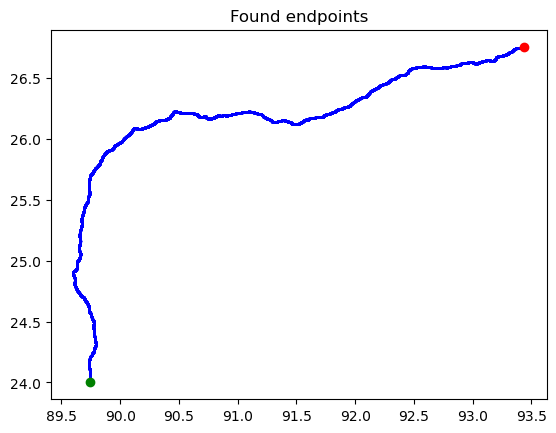

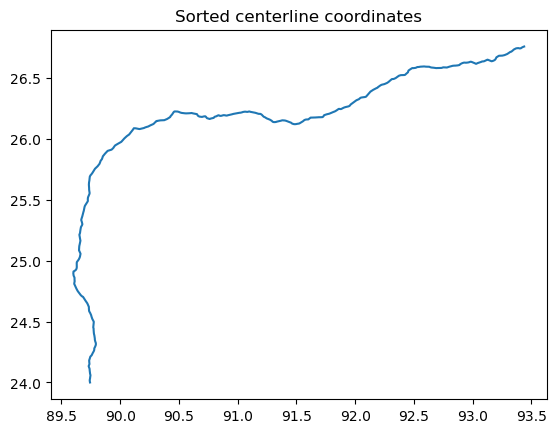

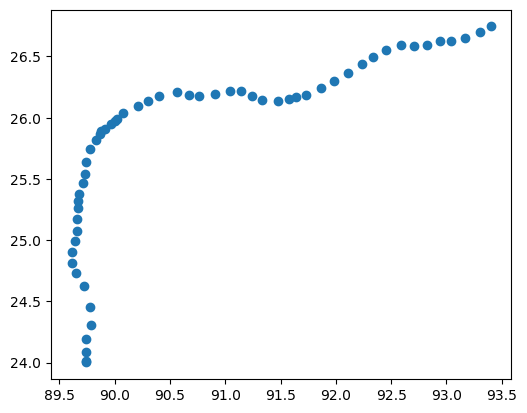

In [54]:
### TESTING CENTERLINE ORDERING ALGORITHM FOR SWORD CENTERLINES

featureName = 'brahmaputra'
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full.shp")[0]
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')

cl_gdf, line, cl_gdf_points = sort_SWORD_cl(cldir,showPlots=True)

cl_gdf_points.plot()


In [14]:
# ------------------------------ STATICS ------------------------------

datadir = "/Volumes/OneTouch/work/SWOTC/"+featureName+"/PIXC/"
wdir = "/Volumes/OneTouch/work/SWOTbraided/scripts/"
odir = datadir+"extracted/"
figdir = "/Volumes/OneTouch/work/SWOTbraided/figs/"+featureName
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
print(cldir)
isExist = os.path.exists(odir)
if not isExist:
    os.makedirs(odir)

/Volumes/OneTouch/work/SWORD/v16/brahmaputra/brahmaputra_full.shp


In [5]:
########################################### Extracting centerlines from water mask ##############################

# read in LF and HF S2 masks and trim data to mask based on season
# Load in the SWOWT PIXC file we are interested in:
filename =  "/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc" #LF
#filename =  "/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc" #HF

pixcdate = os.path.basename(filename)[29:37]

LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

if int(pixcdate[4:6]) in LFmonths:
    water_mask_tiff = glob.glob('/Volumes/OneTouch/work/water_masks/brahmaputra/S2*LF*')
    with rasterio.open(water_mask_tiff[0]) as water_mask:
        water_mask_data= water_mask.read(1)  # Read the first band (binary mask)
        mask_transform = water_mask.transform  # Get the affine transform
        mask_crs = water_mask.crs  # Get the CRS (coordinate reference system)
        season = 'LF'

if int(pixcdate[4:6]) in HFmonths:
    water_mask_tiff = glob.glob('/Volumes/OneTouch/work/water_masks/brahmaputra/S2*HF*')
    with rasterio.open(water_mask_tiff[0]) as water_mask:
        water_mask_data= water_mask.read(1)  # Read the first band (binary mask)
        mask_transform = water_mask.transform  # Get the affine transform
        mask_crs = water_mask.crs  # Get the CRS (coordinate reference system)
        season = 'HF'

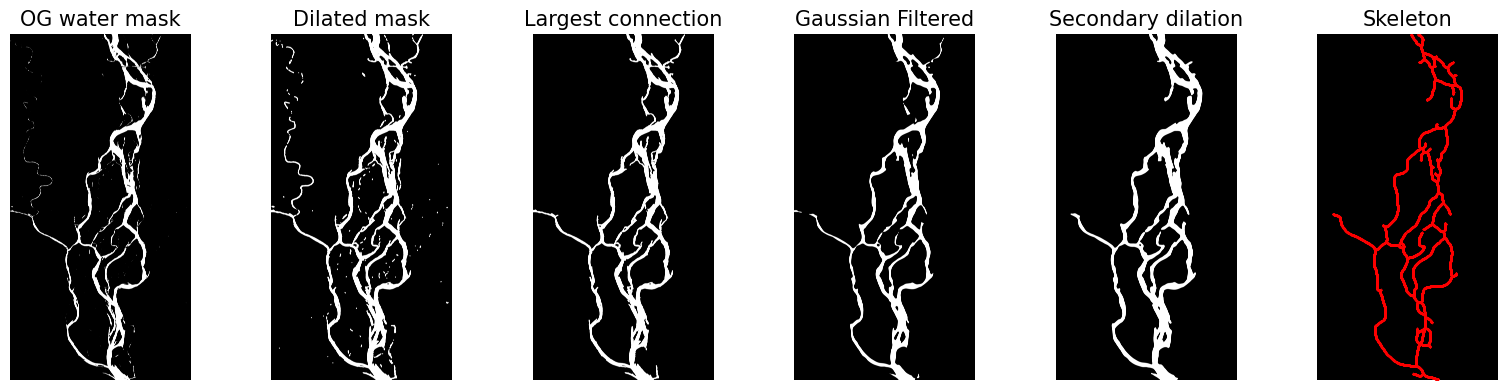

In [6]:
### Simplify water mask before skeletonization

# Step 1: buffer water mask to combine small geometries (across dams, bridges, etc)
mask_image = water_mask_data

if season == 'LF':
    # Step 1: buffer water mask to combine small geometries (across dams, bridges, etc)
    dilated_mask = binary_dilation(mask_image, footprint=createKernel(10))

    # Step 2: Select only the largest connected structure
    labeled_mask, num_features = label(dilated_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())

    # - Ignore background (label 0)
    component_sizes[0] = 0

    # - Find the label of the largest component and select only mask with this label
    largest_component_mask = (labeled_mask == component_sizes.argmax())

    # Step 3. Perform gaussian smoothing
    smoothed_mask = gaussian(largest_component_mask.astype(float), sigma=20)
    smoothed_mask = smoothed_mask > 0.6  # Adjustable threshold

    # Step 3.1: Select again the largest connected structure
    labeled_mask, num_features = label(smoothed_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0 # Setting largest component (being the background) to zero... need to make this more robust in case background is not connected
    largest_component_mask_smoothed = (labeled_mask == component_sizes.argmax())

    # Step 3.2: Perform secondary dilation
    dilated_mask2 = binary_dilation(largest_component_mask_smoothed, footprint=createKernel(10))

else:
    dilated_mask = binary_dilation(mask_image, footprint=createKernel(10))

    # Step 2: Select only the largest connected structure
    labeled_mask, num_features = label(dilated_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())

    # - Ignore background (label 0)
    component_sizes[0] = 0

    # - Find the label of the largest component and select only mask with this label
    largest_component_mask = (labeled_mask == component_sizes.argmax())

    # Step 3. Perform gaussian smoothing
    smoothed_mask = gaussian(largest_component_mask.astype(float), sigma=30)
    smoothed_mask = smoothed_mask > 0.8  # Adjustable threshold


    # Step 3.1: Select again the largest connected structure
    labeled_mask, num_features = label(smoothed_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0 # Setting largest component (being the background) to zero... need to make this more robust in case background is not connected
    largest_component_mask_smoothed = (labeled_mask == component_sizes.argmax())

    # Step 3.2: Perform secondary dilation
    dilated_mask2 = binary_dilation(largest_component_mask_smoothed, footprint=createKernel(20))


# Step 4. Perform skeletonization
# With gaussian smoothing:
skeleton = skeletonize(dilated_mask2)
# Without gaussian smoothing:
#skeleton = skeletonize(largest_component_mask)

# Step 5. Find endpoints
endpoints = find_endpoints(skeleton)


# display results
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(mask_image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('OG water mask', fontsize=15)

ax[1].imshow(dilated_mask, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Dilated mask', fontsize=15)

ax[2].imshow(largest_component_mask, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Largest connection', fontsize=15)

ax[3].imshow(smoothed_mask, cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('Gaussian Filtered', fontsize=15)

ax[4].imshow(dilated_mask2, cmap=plt.cm.gray)
ax[4].axis('off')
ax[4].set_title('Secondary dilation', fontsize=15)


ax[5].imshow(np.zeros_like(skeleton), cmap='gray')
y, x = np.where(skeleton == 1)  # Get skeleton coordinates
ax[5].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
ax[5].axis('off')
ax[5].set_title('Skeleton', fontsize=15)


fig.tight_layout()
plt.show()

Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!


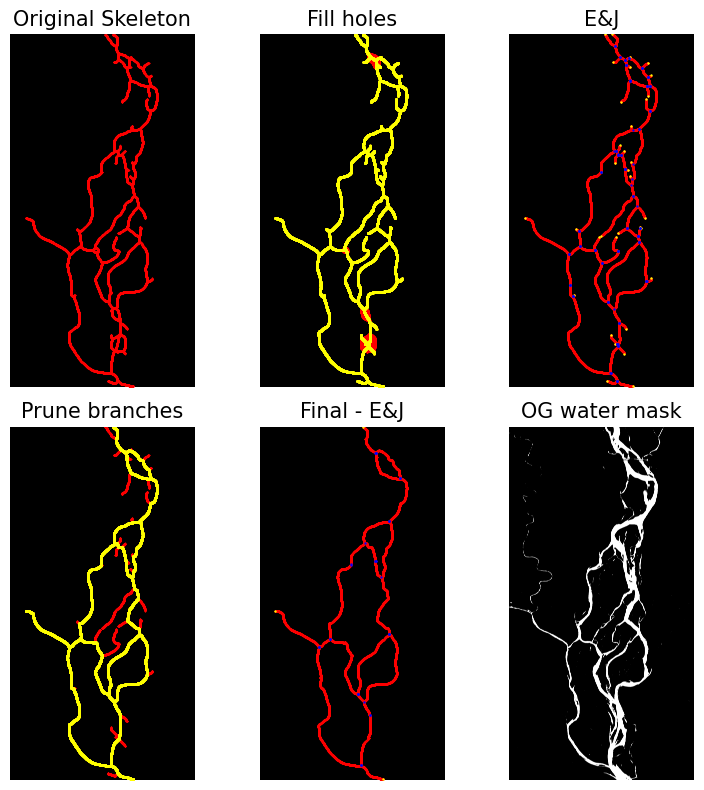

In [7]:
################### Skeletonize ################### 
# 1. Compute skeleton from mask, 
# 2. Fill small holes based on input hole size
# 3. Compute end and joint points (for plotting)
# 4. Perform initial branch pruning based on threshold branch length
# 5. Iteratively reskeletonize and prune branches until length of endpoints is unchanging
# 6. Plot results


# Compute skeleton
skeleton = skeletonize(dilated_mask2)

# Fill small holes
filled_skeleton = fill_small_holes(skeleton, max_hole_size=300) # hole size is radius in pixels

# skeletonize again
skeleton2 = skeletonize(filled_skeleton)

# Compute joints and endpoints for plotting
endpoints = find_endpoints(skeleton2)
joints, joints_removed_mask = find_joints(skeleton2)

# display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(np.zeros_like(skeleton), cmap='gray')
y, x = np.where(skeleton == 1)  # Get skeleton coordinates
ax[0].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
ax[0].axis('off')
ax[0].set_title('Original Skeleton', fontsize=15)

ax[1].imshow(np.zeros_like(skeleton), cmap='gray')
y, x = np.where(filled_skeleton == 1)  # Get skeleton coordinates
ax[1].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where(skeleton2 == 1) 
ax[1].scatter(x, y, color='yellow', s=0.5) 
ax[1].axis('off')
ax[1].set_title('Fill holes', fontsize=15)

ax[2].imshow(np.zeros_like(skeleton), cmap='gray')
y, x = np.where(skeleton2 == 1)  # Get skeleton coordinates
ax[2].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where(endpoints == 1) 
ax[2].scatter(x, y, color='yellow', s=0.5) 
y, x = np.where(joints == 1) 
ax[2].scatter(x, y, color='blue', s=0.5) 
ax[2].axis('off')
ax[2].set_title('E&J', fontsize=15)

# -------------------- Recompute endpoints/jointpoints and prune again

# Prune branches, then iterate through pruning algorithm until no changes occur!
threshold_length=600
pruned_skeleton = prune_branches(skeleton2, threshold_length)


# Fill holes after first pruning
# filled_skeleton = fill_small_holes(pruned_skeleton, max_hole_size=300) # hole size is radius in pixels

#### Do this in a loop until length of endpoints does not change
pruned_skeleton = skeletonize(pruned_skeleton)
endpoints_len_new = 100
i = 0
while True:
    endpoints = find_endpoints(pruned_skeleton)
    y, x = np.where(endpoints == 1) 
    endpoints_len = len(x)

    threshold_length=600
    if endpoints_len_new == endpoints_len:
        final_skeleton = skeletonize(pruned_skeleton) # get rid of areas with 2 pixels width
        break
    
    print('Running prune branches...')
    pruned_skeleton = prune_branches(pruned_skeleton, threshold_length) # APPLY pruning alg!!
    i +=1
    # Compute length of endpoints now...
    y, x = np.where(endpoints == 1) 
    endpoints_len_new = len(x)

print('Pruning algorithm applied '+str(i)+' times!')


ax[3].imshow(np.zeros_like(skeleton), cmap='gray')
y, x = np.where(skeleton2 == 1)  # Get skeleton coordinates
ax[3].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where(final_skeleton == 1) 
ax[3].scatter(x, y, color='yellow', s=0.5) 
ax[3].axis('off')
ax[3].set_title('Prune branches', fontsize=15)


# Recompute joints and ends for plotting
endpoints = find_endpoints(final_skeleton)
joints, joints_removed_mask = find_joints(final_skeleton)

# pruned_skeleton = skeletonize(pruned_skeleton)
# endpoints = find_endpoints(pruned_skeleton)
# joints, joints_removed_mask = find_joints(pruned_skeleton)
# threshold_length=600
# pruned_skeleton2 = prune_branches(pruned_skeleton, threshold_length)
# pruned_skeleton2 = prune_branches(pruned_skeleton2, threshold_length) # APPLY twice!
# final_skeleton = skeletonize(pruned_skeleton2) # get rid of areas with 2 pixels width


ax[4].imshow(np.zeros_like(pruned_skeleton), cmap='gray')
y, x = np.where(pruned_skeleton == 1)  # Get skeleton coordinates
ax[4].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where(endpoints == 1) 
ax[4].scatter(x, y, color='yellow', s=0.5) 
y, x = np.where(joints == 1) 
ax[4].scatter(x, y, color='blue', s=0.5) 
ax[4].axis('off')
ax[4].set_title('Final - E&J', fontsize=15)

ax[5].imshow(mask_image, cmap=plt.cm.gray)
ax[5].axis('off')
ax[5].set_title('OG water mask', fontsize=15)


fig.tight_layout()
plt.show()

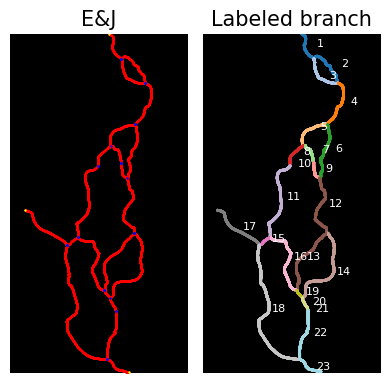

In [8]:

# Now, set ID values to each channel....
endpoints = find_endpoints(final_skeleton)
joints, joints_removed_mask = find_joints(final_skeleton)

# id = np.where(endpoints)[0] == np.min(np.where(endpoints)[0])
# start_pixel = (np.where(endpoints)[0][id][0], np.where(endpoints)[1][id][0]) # (y,x), choose endpoint with the smallest y value (most north endpoint)

joint_coords = np.where(joints == 1)  # Get skeleton coordinates
joint_coords = np.dstack((joint_coords[0],joint_coords[1]))
joint_coords = joint_coords.reshape(-1, 2)


# Assign labels
labeled_skeleton = assign_unique_ids_to_branches(final_skeleton,joint_coords,None)

# Get coordinates and labels of all labeled pixels
y_coords, x_coords = np.where(labeled_skeleton > 0)
labels = labeled_skeleton[y_coords, x_coords]

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(np.zeros_like(final_skeleton), cmap='gray')
y, x = np.where(final_skeleton == 1)  # Get skeleton coordinates
ax[0].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where(endpoints == 1) 
ax[0].scatter(x, y, color='yellow', s=0.5) 
y, x = np.where(joints == 1) 
ax[0].scatter(x, y, color='blue', s=0.5) 
ax[0].axis('off')
ax[0].set_title('E&J', fontsize=15)


# View label
ax[1].imshow(np.zeros_like(final_skeleton), cmap='gray')
ax[1].scatter(x_coords, y_coords, c=labels, cmap='tab20', s=1)

# Annotate each branch with its ID near its center
unique_labels = np.unique(labels)
for branch_id in unique_labels:
    branch_yx = np.column_stack(np.where(labeled_skeleton == branch_id))
    if len(branch_yx) > 0:
        # Find approximate center by using the median position
        center_y, center_x = np.median(branch_yx, axis=0).astype(int)
        ax[1].text(center_x+300, center_y, str(branch_id), color="white", fontsize=8, ha='center')

ax[1].axis('off')
y, x = np.where((final_skeleton == 1) & (labeled_skeleton == 0)) 
ax[1].scatter(x, y, color='yellow', s=1) # These are skeleton points without a label


ax[1].set_title('Labeled branch', fontsize=15)

fig.tight_layout()
plt.show()

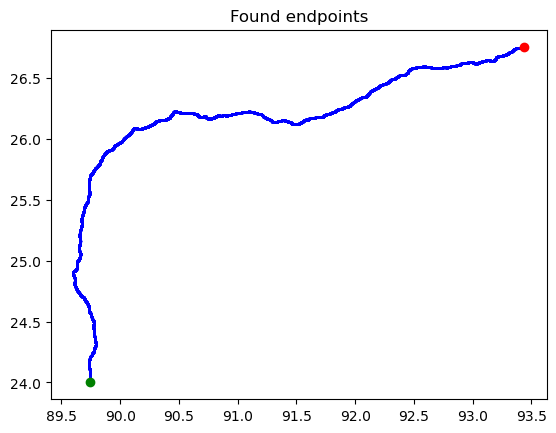

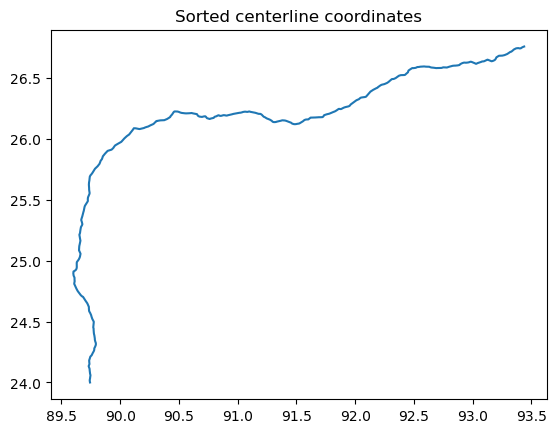

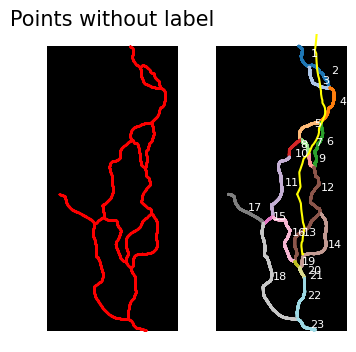

In [57]:
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')
# IF SWORD cl:
# cl = pc.order_cl_shp(cldir)
sword_cl_gdf, sword_cline, sword_cl_points = sort_SWORD_cl(cldir,showPlots=True) # Output is gdf

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(np.zeros_like(final_skeleton), cmap='gray')
y, x = np.where(final_skeleton == 1)  # Get skeleton coordinates
ax[0].scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots
y, x = np.where((final_skeleton == 1) & (labeled_skeleton == 0)) 
ax[0].scatter(x, y, color='yellow', s=1)  # Plot skeleton points as red dots
ax[0].axis('off')
ax[0].set_title('Points without label', fontsize=15)

# View label
ax[1].imshow(np.zeros_like(final_skeleton), cmap='gray')
ax[1].scatter(x_coords, y_coords, c=labels, cmap='tab20', s=1)

# Annotate each branch with its ID near its center
unique_labels = np.unique(labels)
for branch_id in unique_labels:
    branch_yx = np.column_stack(np.where(labeled_skeleton == branch_id))
    if len(branch_yx) > 0:
        # Find approximate center by using the median position
        center_y, center_x = np.median(branch_yx, axis=0).astype(int)
        ax[1].text(center_x+300, center_y, str(branch_id), color="white", fontsize=8, ha='center')

ax[1].axis('off')
y, x = np.where((final_skeleton == 1) & (labeled_skeleton == 0)) 
ax[1].scatter(x, y, color='yellow', s=1) # These are skeleton points without a label

# Add SWORD centerline
# Project to OG centerline:
SWORD_pixelcoords = latlon_to_pixel_coordinates(water_mask_tiff[0],sword_cl_gdf.get_coordinates().y,sword_cl_gdf.get_coordinates().x)
y, x = np.where((final_skeleton == 1)) 
min_x, max_x = x.min()-300, x.max()+300
min_y, max_y = y.min()-300, y.max()+300
ax[1].plot(SWORD_pixelcoords.x, SWORD_pixelcoords.y,linestyle='solid', color='yellow') # SWOT CL
ax[1].set_xlim(min_x, max_x)
ax[1].set_ylim(max_y, min_y)


plt.show()




,branch_id,geometry
0,1,"LINESTRING (89.75800 24.41437, 89.75791 24.414..."
1,2,"LINESTRING (89.80247 24.36909, 89.80247 24.369..."
2,3,"LINESTRING (89.80238 24.36891, 89.80229 24.368..."
3,4,"LINESTRING (89.78279 24.29211, 89.78279 24.292..."
4,5,"LINESTRING (89.73860 24.25294, 89.73851 24.253..."
5,6,"LINESTRING (89.76869 24.19239, 89.76878 24.192..."
6,7,"LINESTRING (89.75809 24.22087, 89.75800 24.220..."
7,8,"LINESTRING (89.71407 24.21521, 89.71407 24.215..."
8,9,"LINESTRING (89.76851 24.19239, 89.76842 24.192..."
9,10,"LINESTRING (89.71416 24.21503, 89.71407 24.21512)"


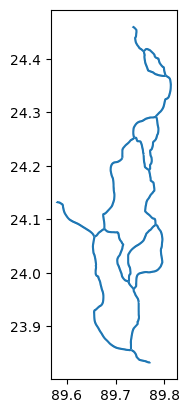

In [11]:
# Extract skeleton centerlines as gpd line geometries (in lat,lon coordinates)

line_data = []
for branch in np.unique(labeled_skeleton):

    if branch == 0:
        continue

    # extract subskeleton
    subskel = np.zeros_like(labeled_skeleton)
    subskel[labeled_skeleton == branch] =  1

    # order raster from endpoint
    pixel_coords_x,pixel_coords_y = order_raster_from_endpoint(subskel,branch)

    # Convert ordered pixel coordinates to lat lon
    line = pixel_coordinates2latlonline(water_mask_tiff[0],pixel_coords_y,pixel_coords_x,branch,reverse=True)

    # append gdf line to overall gdf with branch id
    line_data.append({'branch_id': branch, 'geometry': line})

cl_gdf_labeled = gpd.GeoDataFrame(line_data, crs="EPSG:4326")  # Assuming WGS84
cl_gdf_labeled.plot()
cl_gdf_labeled


No centerline buffer to trim to.


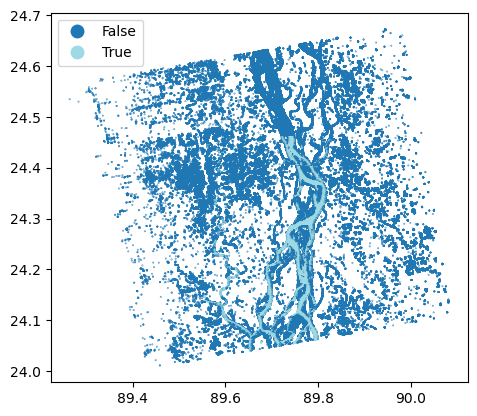

In [15]:
# Read in one PIXC image
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0] # Read in SWORD shapefile to filter initial read in
cl = gpd.read_file(cldir)
original_crs = 'EPSG:4326'
hemi='north'

# Read in data and buffer initially for all centerlines
cl_buffered = pc.get_width_dependent_buffer(cl,original_crs,'north',2000) #gdf


#filename =  "/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc"
pixcdate = os.path.basename(filename)[29:37]
pixc_gdf = pc.readPIXC(filename,gdf_buffered = []) # cl is a geodataframe

# Trim data to mask
trimmed_gdf, pixc_gdf = trim2mask(pixc_gdf,water_mask_tiff[0],figdir,pixcdate)

In [16]:
# Trim PIXC data to channels
pixc_gdf_wChannels = gpd.GeoDataFrame()

for id in cl_gdf_labeled.branch_id:

    # Select a channel centerline
    selChannel = cl_gdf_labeled.iloc[[int(id)-1]]
    # Buffer around channel
    buffer_width = 1000 ####### !Change to a channel width dependent buffer!
    gdf_buffered = pc.get_width_dependent_buffer(selChannel,'EPSG:4326','north',buffer_width)

    # Trim SWOT PIXC to buffer
    clipped_gdf = gpd.clip(trimmed_gdf, gdf_buffered) # Use 'trimmed_gdf' to use water mask trimmed data
    clipped_gdf = clipped_gdf.copy()
    
    if len(clipped_gdf) > 0:
        # # Plot also the data intersection with the buffer
        # fig, ax = plt.subplots(figsize=(10, 10))
        # selChannel.plot(ax=ax, color='blue', label='Centerline', linewidth=2)
        # gdf_buffered.plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
        # clipped_gdf.plot(ax=ax, color='purple',markersize=0.1)
        # ax.set_title('Centerline and Buffered Area, Channel No. '+str(int(id-1)), fontsize=15)
        # ax.set_xlabel('Longitude', fontsize=12)
        # ax.set_ylabel('Latitude', fontsize=12)
        # ax.legend()
        # plt.savefig(figdir+'/channel_data'+str(int(id-1))+'.png')
        # #plt.show()

        # project SWOT PIXC to channel centerline
        clipped_gdf['dist'] = pc.projectToCenterline(selChannel,clipped_gdf[['geometry']],hemi)
        clipped_gdf['channelID'] = int(selChannel.branch_id)

        pixc_gdf_wChannels = pd.concat([pixc_gdf_wChannels, clipped_gdf])



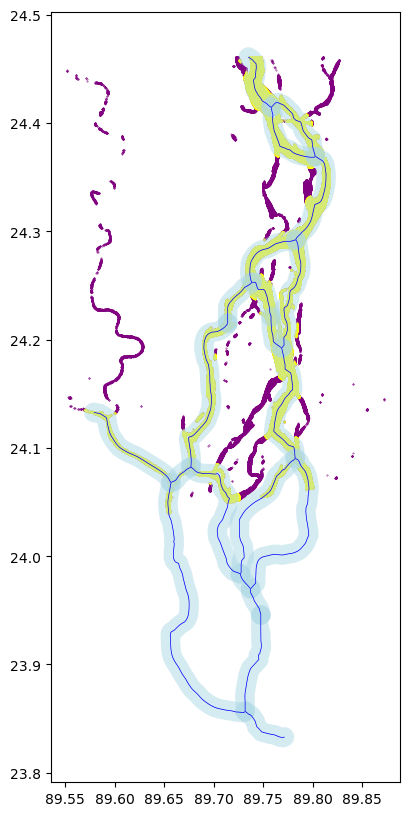

In [17]:
# Show which data are selected by pixc_gdf_wChannels

fig, ax = plt.subplots(figsize=(10, 10))

trimmed_gdf.plot(ax=ax, color='purple',markersize=0.1)
pixc_gdf_wChannels.plot(ax=ax, color='yellow',markersize=0.1)
for id in cl_gdf_labeled.branch_id:

    # Select a channel
    selChannel = cl_gdf_labeled.iloc[[int(id)-1]]
    #print(selChannel)

    buffer_width = 1000
    gdf_buffered = pc.get_width_dependent_buffer(selChannel,'EPSG:4326','north',buffer_width)

    selChannel.plot(ax=ax, color='blue', label='Centerline', linewidth=0.5)
    gdf_buffered.plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')

plt.show()

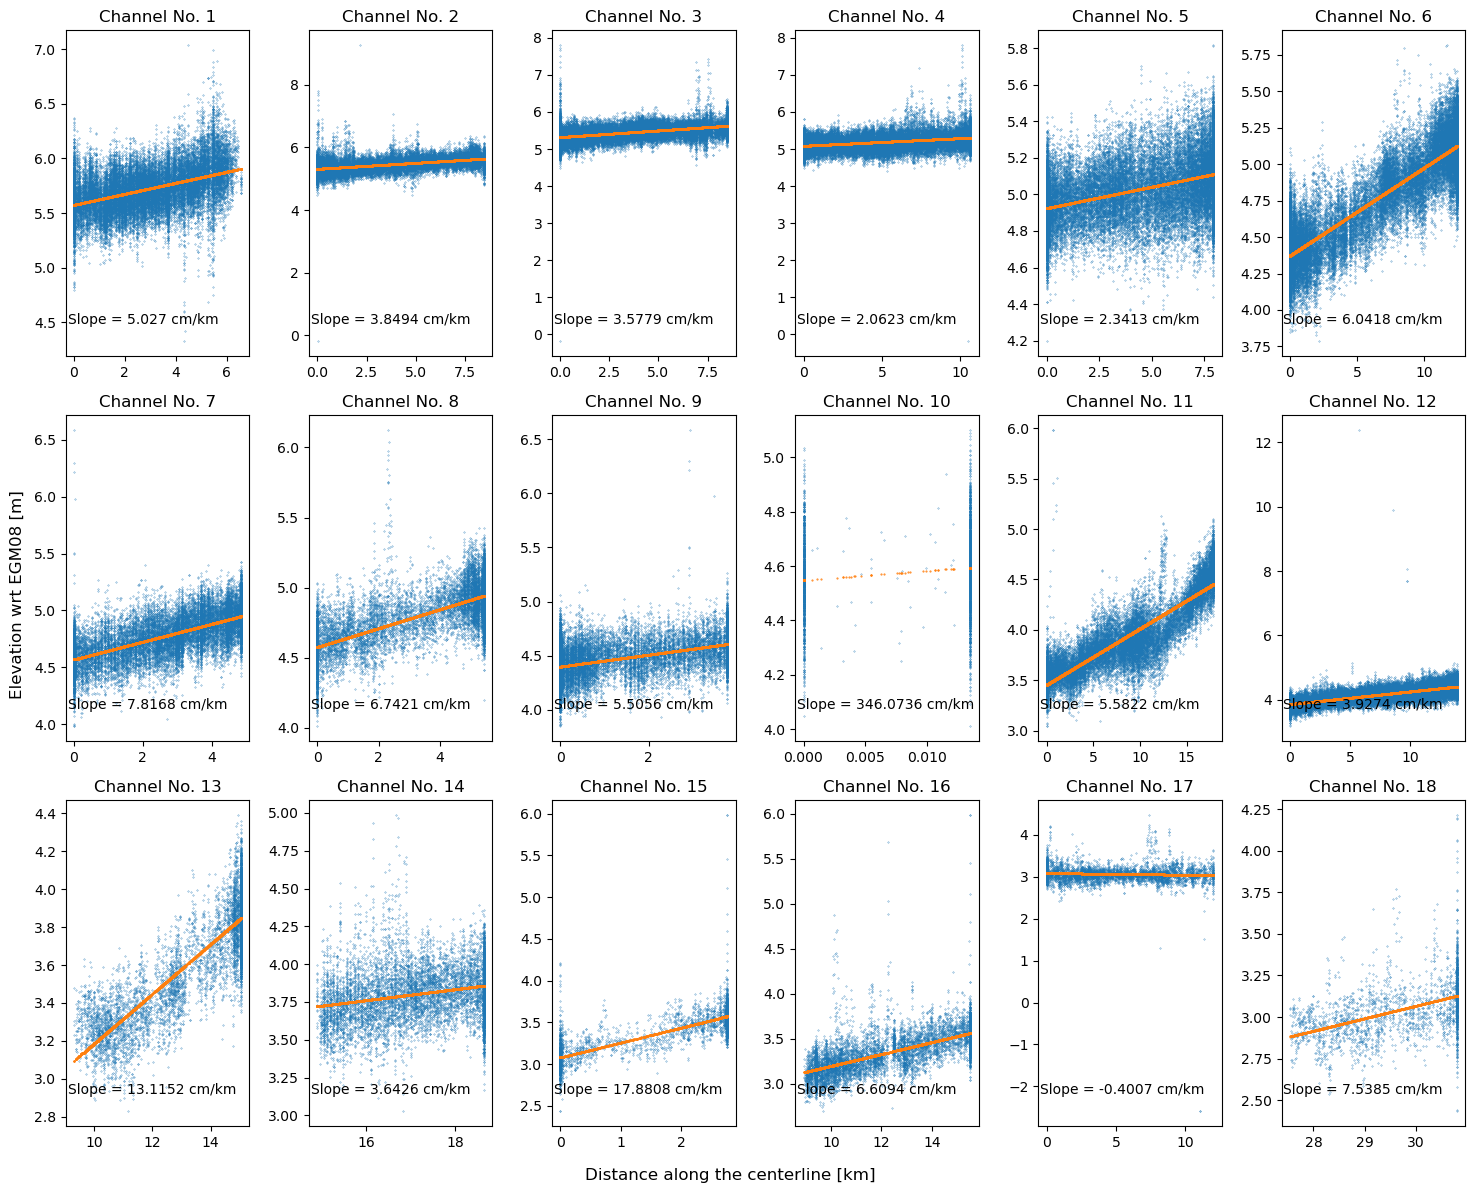

In [18]:

fig, axs = plt.subplots(ncols=6, nrows=int(np.ceil(len(np.unique(pixc_gdf_wChannels.channelID))/6)), figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Channel Projections", fontsize=18, y=0.95)

for id, ax in zip(np.unique(pixc_gdf_wChannels.channelID), axs.ravel()):

    sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID']==id]
    regr = LinearRegression()
    regr.fit(sub_channel[['dist']], sub_channel[['heightEGM']])
    h_pred = regr.predict(sub_channel[['dist']])

    ax.plot(sub_channel.dist/1000, sub_channel.heightEGM,'.',markersize=0.5)
    ax.plot(sub_channel.dist/1000, h_pred,'.',markersize=1)
    ax.set_title('Channel No. '+str(int(id)))
    ax.text(0.01,0.1,'Slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km',transform = ax.transAxes)
    #ax.set_ylim(2,7)


fig.supxlabel('Distance along the centerline [km]')
fig.supylabel('Elevation wrt EGM08 [m]')
fig.tight_layout()
plt.savefig(figdir+'/channel_slope_all.png')


            x          y     reach_id     reach_len  n_nodes        wse  \
0   89.652082  24.735158  45253000055  10188.666850       51   7.600000   
1   89.614154  24.817036  45253000065  10152.567548       51   8.100000   
2   89.672461  25.321745  45253000071   3249.797543       16  14.700000   
3   89.681355  25.379251  45253000101  10020.481156       50  14.900001   
4   89.733588  25.537201  45253000151   7151.142544       36  14.900001   
5   89.738099  25.638877  45253000161  16180.307458       81  15.200000   
6   89.780909  25.743478  45253000291   9399.183076       47  17.700001   
7   89.709981  25.464546  45253000311   9994.487973       50  14.900001   
8   89.744557  24.189547  45253001525  13560.335521       68   2.600000   
9   89.784661  24.305646  45253001535  14008.702426       70   3.500000   
10  89.773170  24.452330  45253001545  19815.509846       99   6.100000   
11  89.727084  24.619948  45253001575  19762.261219       99   7.700000   
12  89.610920  24.903049 

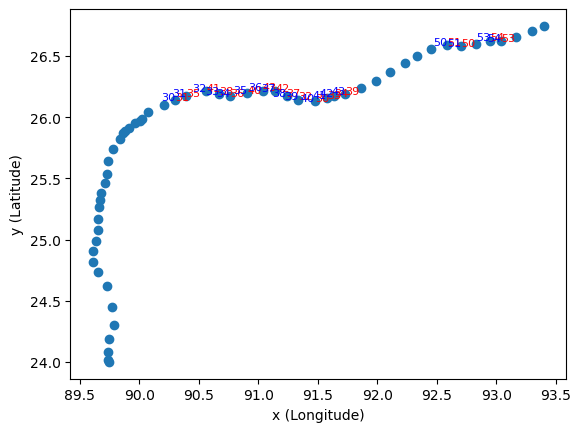

/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CH. 3 slope = 4.8922 cm/km
CH. 3 slope = 4.8938 cm/km
                    geometry
0  POINT (89.74350 24.00031)
1  POINT (89.74160 24.01469)
2  POINT (89.74191 24.08102)
3  POINT (89.74456 24.18955)
4  POINT (89.78466 24.30565)
5  POINT (89.77317 24.45233)
6  POINT (89.72708 24.61995)
7  POINT (89.65208 24.73516)
8  POINT (89.61415 24.81704)
9  POINT (89.61092 24.90305)
                                            geometry      reachID   width
0  LINESTRING (89.74350 24.00017, 89.74350 24.00044)  45253001955  3667.0
0  LINESTRING (89.74304 24.00050, 89.74333 24.000...  45253001935  4299.0
0  LINESTRING (89.74322 24.02888, 89.74323 24.029...  45253001965  3282.5
0  LINESTRING (89.73098 24.13307, 89.73128 24.133...  45253001525  4212.5
0  LINESTRING (89.76912 24.24582, 89.76942 24.246...  45253001535  3395.0
0  LINESTRING (89.78355 24.36577, 89.78326 24.366...  45253001545  3931.0
0  LINESTRING (89.75675 24.53873, 89.75670 24.539...  45253001575  3531.0
0  LINESTRING (89.68605 24.70137, 8

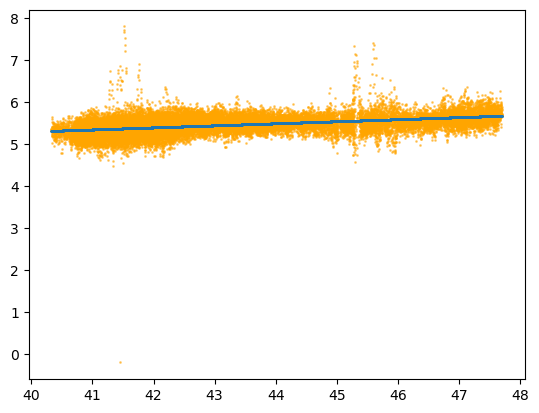

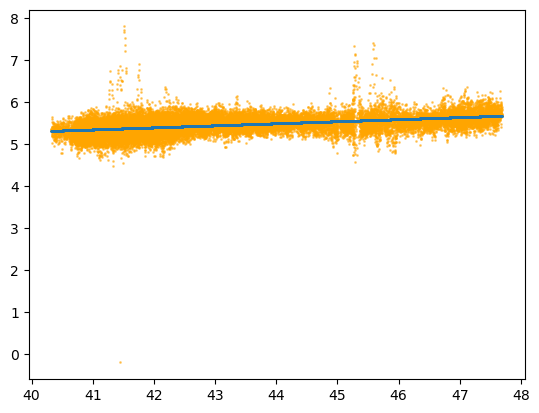

In [ ]:
## YOU ARE HERE! Testing SWORD projection...

cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')
cl_df = pc.order_cl(cl,'lat')
cl_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(cl_df['x'],cl_df['y']),crs='EPSG:4326')


sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'] == 3]

sub_channel['dist_SWORDcl'] = pc.projectToCenterline(cl_gdf,sub_channel[['geometry']],hemi)
sub_channel['dist_SWORDcl_new'] = pc.projectToCenterline(sword_cl_points,sub_channel[['geometry']],hemi)

regr = LinearRegression()
regr.fit(sub_channel[['dist_SWORDcl']], sub_channel[['heightEGM']])
h_pred = regr.predict(sub_channel[['dist_SWORDcl']])
print('CH. '+str(int(3))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
plt.figure()
plt.scatter(sub_channel['dist_SWORDcl']/1000, sub_channel['heightEGM'], alpha=0.5, c='orange', s=1.0, label='3')
plt.plot(sub_channel.dist_SWORDcl/1000, h_pred,'.',markersize=1)

regr = LinearRegression()
regr.fit(sub_channel[['dist_SWORDcl_new']], sub_channel[['heightEGM']])
h_pred = regr.predict(sub_channel[['dist_SWORDcl_new']])
print('CH. '+str(int(3))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
plt.figure()
plt.scatter(sub_channel['dist_SWORDcl_new']/1000, sub_channel['heightEGM'], alpha=0.5, c='orange', s=1.0, label='3')
plt.plot(sub_channel.dist_SWORDcl_new/1000, h_pred,'.',markersize=1)


print(cl_gdf.head(10))
print(sword_cl_gdf.head(10))
print(sword_cl_points.head(10))

CH. 1 slope = 5.6872 cm/km
CH. 2 slope = 5.3121 cm/km
CH. 3 slope = 4.8938 cm/km
CH. 4 slope = 2.5317 cm/km
CH. 5 slope = 3.1282 cm/km
CH. 6 slope = 6.5322 cm/km
CH. 7 slope = 9.9321 cm/km
CH. 8 slope = 7.172 cm/km
CH. 9 slope = 5.311 cm/km
CH. 10 slope = 11.0474 cm/km
CH. 11 slope = 6.8759 cm/km
CH. 12 slope = 4.5222 cm/km
CH. 13 slope = 16.1693 cm/km
CH. 14 slope = 4.2954 cm/km
CH. 15 slope = 23.5309 cm/km
CH. 16 slope = 12.1745 cm/km
CH. 17 slope = -0.6779 cm/km
CH. 18 slope = 6.8995 cm/km


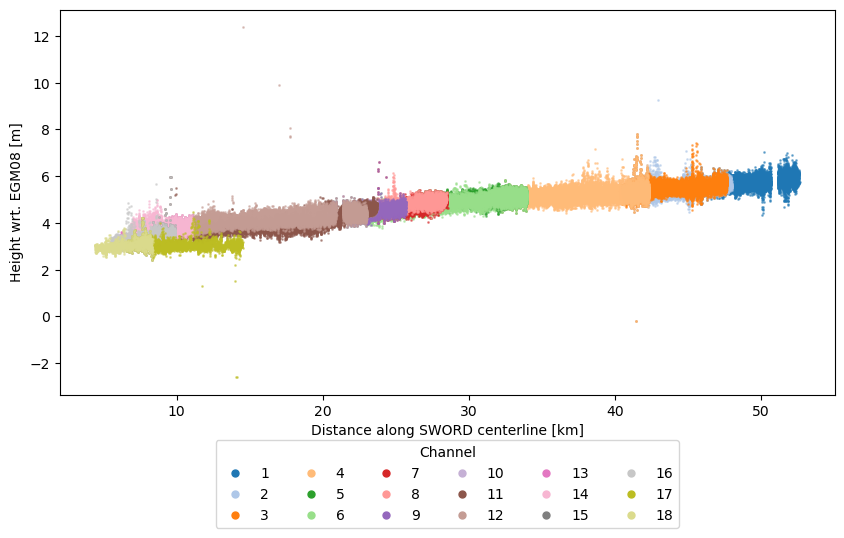

In [61]:
## Plot projected data on one plot, colored by unique channel ID
# Compare with projected data if it were projected to SWORD v16 CL (and associated computed slope)

#pixc_gdf_wChannels['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_gdf['geometry'],pixc_gdf_wChannels[['geometry']],hemi)
#pixc_gdf_wChannels['dist_SWORDcl'] = pc.projectToCenterline(gpd.GeoDataFrame(geometry=[sword_cline],crs='EPSG:4326'),pixc_gdf_wChannels[['geometry']],hemi)
pixc_gdf_wChannels['dist_SWORDcl'] = pc.projectToCenterline(sword_cl_points,pixc_gdf_wChannels[['geometry']],hemi)


# Define colors to map each unique date to a specific color
unique_channels = pixc_gdf_wChannels['channelID'].unique()
colors = plt.cm.tab20(range(len(unique_channels)))  # Use a colormap with distinct colors
channel_color_map = dict(zip(unique_channels, colors))

# Create the plot with each date as a separate scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
for channelID, color in channel_color_map.items():
    sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'] == channelID]

    regr = LinearRegression()
    regr.fit(sub_channel[['dist_SWORDcl']], sub_channel[['heightEGM']])
    h_pred = regr.predict(sub_channel[['dist_SWORDcl']])
    print('CH. '+str(int(channelID))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')

    ax.scatter(sub_channel['dist_SWORDcl']/1000, sub_channel['heightEGM'], alpha=0.5, c=[color], s=1.0, label=channelID)

# Add a legend with formatted date labels
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=5, label=date) 
                  for date, color in channel_color_map.items()]
ax.legend(handles=legend_handles, title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=6)

plt.xlabel("Distance along SWORD centerline [km]")
plt.ylabel("Height wrt. EGM08 [m]")
plt.show()

#pixc_gdf_wChannels.plot(kind='scatter', x='dist_SWORDcl',y='heightEGM',s=0.3,style='.',alpha=1,c=pixc_gdf_wChannels.channelID,cmap='tab20',figsize=(10, 5))


CH. 3 slope = 3.5779 cm/km
30763


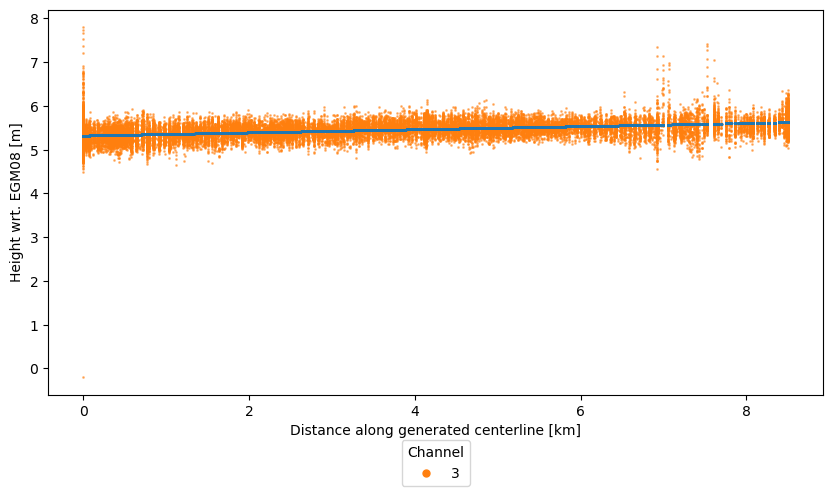

CH. 3 slope = 4.8938 cm/km
30763


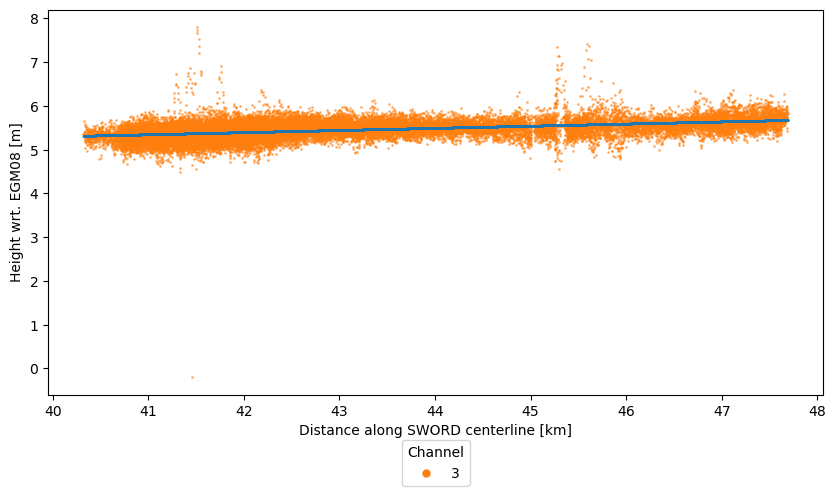

   branch_id                                           geometry
2          3  LINESTRING (89.80238 24.36891, 89.80229 24.368...


/var/folders/z8/rwrj_7dn6nv6_d2803hqbzc00000gn/T/ipykernel_39630/328701619.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


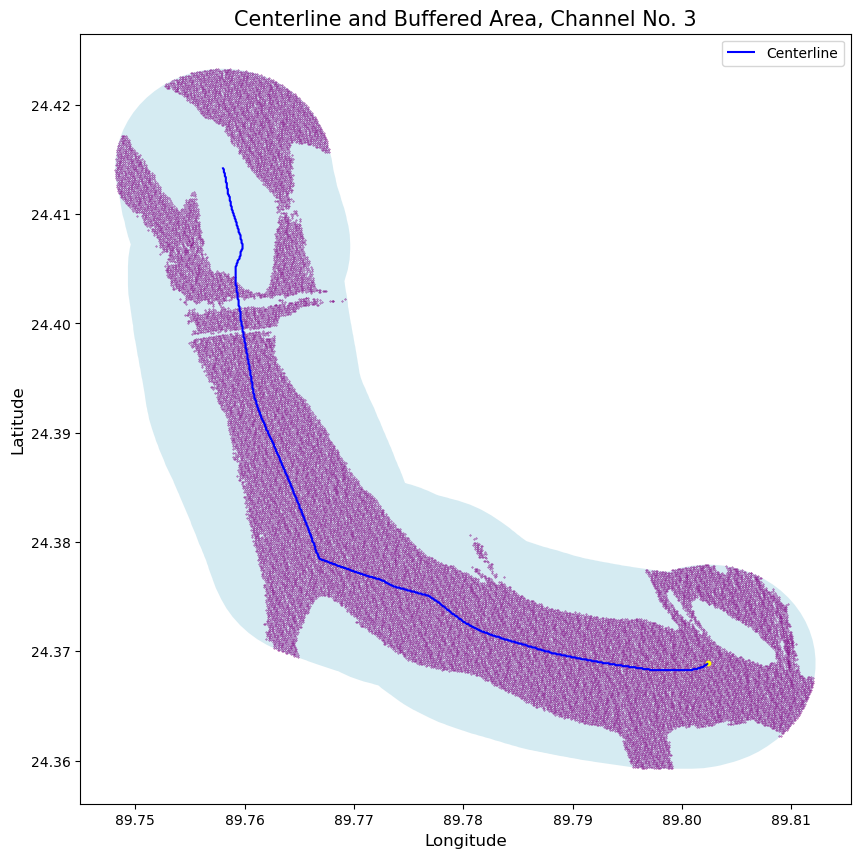

In [62]:

###### Select a few channels

## Plot proj for selected CL# Select just a few channels to compare slopes
selChannels = ['3']
selChannels = list(map(int, selChannels))
filtered_channel_color_map = {k: v for k, v in channel_color_map.items() if k in selChannels}

## Plot now just a few select months for closer look
fig, ax = plt.subplots(figsize=(10, 5))
for channelID, color in filtered_channel_color_map.items():
    sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'] == channelID]

    regr = LinearRegression()
    regr.fit(sub_channel[['dist']], sub_channel[['heightEGM']])
    h_pred = regr.predict(sub_channel[['dist']])

    print('CH. '+str(int(channelID))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    ax.scatter(sub_channel['dist']/1000, sub_channel['heightEGM'], alpha=0.5, c=[color], s=1.0, label=channelID)
    ax.plot(sub_channel.dist/1000, h_pred,'.',markersize=1)

    print(len(sub_channel['dist']/1000))
    #ax.text(0.01,0.1,'CH. '+str(int(channelID))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km',transform = ax.transAxes)


# Add a legend with formatted date labels
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=5, label=date) 
                  for date, color in filtered_channel_color_map.items()]
ax.legend(handles=legend_handles, title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=6)

plt.xlabel("Distance along generated centerline [km]")
plt.ylabel("Height wrt. EGM08 [m]")
plt.show()


## Plot now just a few select months for closer look
fig, ax = plt.subplots(figsize=(10, 5))
for channelID, color in filtered_channel_color_map.items():
    sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'] == channelID]
    regr = LinearRegression()
    regr.fit(sub_channel[['dist_SWORDcl']], sub_channel[['heightEGM']])
    h_pred = regr.predict(sub_channel[['dist_SWORDcl']])
    print('CH. '+str(int(channelID))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    ax.scatter(sub_channel['dist_SWORDcl']/1000, sub_channel['heightEGM'], alpha=0.5, c=[color], s=1.0, label=channelID)



    ax.plot(sub_channel.dist_SWORDcl/1000, h_pred,'.',markersize=1)

    print(len(sub_channel['dist_SWORDcl']/1000))
    #ax.text(0.01,0.1,'CH. '+str(int(channelID))+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km',transform = ax.transAxes)


# Add a legend with formatted date labels
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=5, label=date) 
                  for date, color in filtered_channel_color_map.items()]
ax.legend(handles=legend_handles, title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=6)

plt.xlabel("Distance along SWORD centerline [km]")
plt.ylabel("Height wrt. EGM08 [m]")
plt.show()

from shapely import get_point

for id in selChannels:

    # Select a channel centerline
    selChannel = cl_gdf_labeled.iloc[[int(id)-1]]
    print(selChannel)
    # Buffer around channel
    buffer_width = 1000 ####### !Change to a channel width dependent buffer!
    gdf_buffered = pc.get_width_dependent_buffer(selChannel,'EPSG:4326','north',buffer_width)

    # Get data for this channel
    sub_channel = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'] == id]
    #clipped_gdf = clipped_gdf.copy()
    
    if len(sub_channel) > 0:
        # Plot also the data intersection with the buffer
        fig, ax = plt.subplots(figsize=(10, 10))

        selChannel.plot(ax=ax, color='blue', label='Centerline')
        gdf_buffered.plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
        sub_channel.plot(ax=ax, color='purple',markersize=0.1)

        startpoint = get_point(selChannel.geometry,0)
        startpoint = gpd.GeoDataFrame(geometry=startpoint)
        startpoint.plot(ax=ax, color='yellow',markersize=10)
        
        #plt.scatter(x=startpoint.geometry.x,y=startpoint.geometry.y,color='yellow',s=2)
        ax.set_title('Centerline and Buffered Area, Channel No. '+str(int(id)), fontsize=15)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.legend()
        
        #startpoint.plot(ax=ax, color='yellow',markersize=0.1)

        #plt.savefig(figdir+'/channel_data'+str(int(id-1))+'.png')
        plt.show()


# plt.savefig(figdir+'/channel_data'+str(int(id-1))+'.png')
# #plt.show()




Extracting centerline from raster...
Extracted!
   branch_id                                           geometry
0          1  LINESTRING (89.73860 24.25294, 89.73851 24.253...
Projecting SWOT PIXC to joint centerline...
Projected!
Extracting centerline from raster...
Extracted!
   branch_id                                           geometry
0          2  LINESTRING (89.72665 23.98381, 89.71416 24.215...
Projecting SWOT PIXC to joint centerline...
Projected!


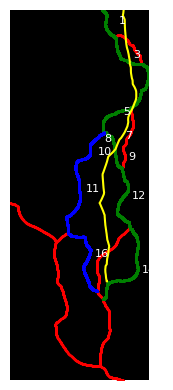

CH. 1 slope = 4.7241 cm/km
CH. 2 slope = 7.956 cm/km


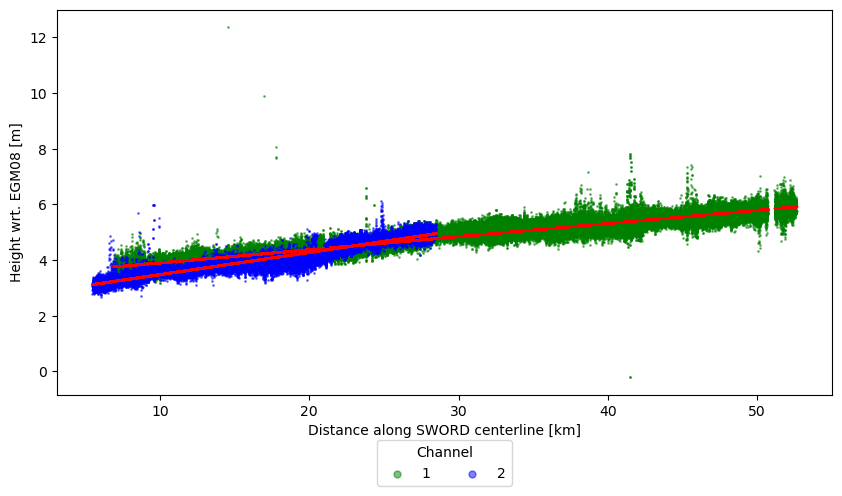

All channels slope = 5.3288 cm/km


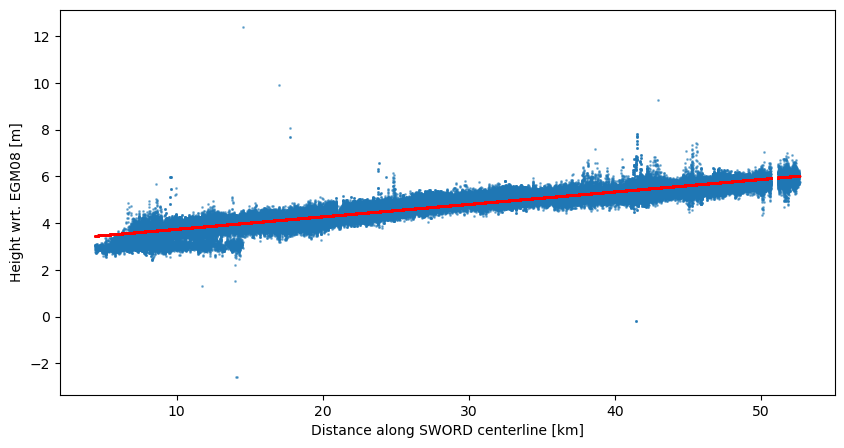

CH. 1 slope = 4.4696 cm/km
CH. 2 slope = 7.4373 cm/km


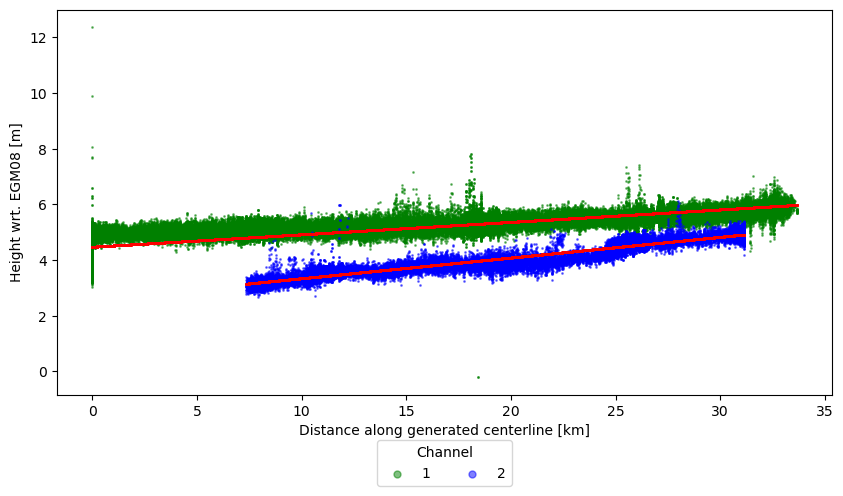

In [66]:
# LF manual
ch1 = ['14','12','9','7','5','4','3','1']
ch2 = ['16','11','10','8']
# HF manual
# ch2 = ['27','25','23','7','4']
# ch1 = ['27','26','19','14','12','11','9','6','3','1']

ch3 = ['13']
ch1 = list(map(int, ch1))
ch2 = list(map(int, ch2))
ch3 = list(map(int, ch3))

fig_branch, ax_branch = plt.subplots(figsize=(4, 4))
ax_branch.imshow(np.zeros_like(pruned_skeleton), cmap='gray')
y, x = np.where(labeled_skeleton > 1)  # Get skeleton coordinates
ax_branch.scatter(x, y, color='red', s=0.05)  # Plot skeleton points as red dots

branch_colors = ['green','blue','purple']

pixc_gdf_wChannels['joint_channel_id'] = 0
pixc_gdf_wChannels['dist_jointChannel'] = 0


# Select data in these three channels, combine, and plot
for i in range(2):
    if i == 0:
        selChannels_list = ch1
    if i == 1:
        selChannels_list = ch2
    if i == 2:
        selChannels_list = ch3

    

    selChannels = selChannels_list #list(map(int, selChannels_list))
    filtered_channel_color_map = {k: v for k, v in channel_color_map.items() if k in selChannels} 

    # ------------ Select all PIXC data associated with these channels and plot projected to CL
    #channels_gdf = pixc_gdf_wChannels[pixc_gdf_wChannels['channelID'].isin(selChannels_list)]
    idx = pixc_gdf_wChannels['channelID'].isin(selChannels_list)
    pixc_gdf_wChannels.loc[idx, 'joint_channel_id'] = i + 1

    # Get connected CL 
    sub_skeleton = np.zeros_like(labeled_skeleton)
    mask = np.isin(labeled_skeleton, selChannels_list)
    sub_skeleton[mask] = 1
    branch = i+1
    line_data = []

    print('Extracting centerline from raster...')
    # order raster from endpoint
    pixel_coords_x,pixel_coords_y = order_raster_from_endpoint(sub_skeleton,branch)

    # Convert ordered pixel coordinates to lat lon
    line = pixel_coordinates2latlonline(water_mask_tiff[0],pixel_coords_y,pixel_coords_x,branch,reverse=True)

    # append gdf line to overall gdf with branch id
    line_data.append({'branch_id': branch, 'geometry': line})

    cl_gdf_joint = gpd.GeoDataFrame(line_data, crs="EPSG:4326")  # Assuming WGS84
    print('Extracted!')
    print(cl_gdf_joint)

    #cl_gdf_joint, cl_gdf_joint = extract_latlon_with_branch_id(water_mask_tiff[0],sub_skeleton)

    # Project selected data to this new centerline
    print('Projecting SWOT PIXC to joint centerline...')
    pixc_gdf_wChannels.loc[idx, 'dist_jointChannel'] = pc.projectToCenterline(cl_gdf_joint,pixc_gdf_wChannels.loc[idx,['geometry']],hemi)
    print('Projected!')

    # ------------ Now plotting selected channels on branch map
    channel_cls = cl_gdf_labeled['branch_id'].isin(selChannels_list)

    y_coords, x_coords = np.where(np.isin(labeled_skeleton, selChannels))
    labels = labeled_skeleton[y_coords, x_coords]
    ax_branch.scatter(x_coords, y_coords, c=branch_colors[i], s=1)

    # ------------ Annotate each branch with its ID near its center
    unique_labels = np.unique(labels)
    for branch_id in unique_labels:
        branch_yx = np.column_stack(np.where(labeled_skeleton == branch_id))
        if len(branch_yx) > 0:
            # Find approximate center by using the median position
            center_y, center_x = np.median(branch_yx, axis=0).astype(int)
            ax_branch.text(center_x+300, center_y, str(branch_id), color="white", fontsize=8, ha='center')

    ax_branch.axis('off')

y, x = np.where(labeled_skeleton >= 1)  # Get skeleton coordinates
# Add SWORD centerline
min_x, max_x = x.min(), x.max()
min_y, max_y = y.min(), y.max()
ax_branch.plot(SWORD_pixelcoords.x, SWORD_pixelcoords.y,linestyle='solid', color='yellow') # SWOT CL
ax_branch.set_xlim(min_x, max_x)
ax_branch.set_ylim(max_y, min_y)
fig_branch.tight_layout()
plt.show()

## Plot proj against SWORD centerline
minDist = 10000
maxDist = 0
fig, ax = plt.subplots(figsize=(10, 5))
for joint_channel in np.unique(pixc_gdf_wChannels['joint_channel_id']):
    if joint_channel == 0:
        continue
    channels_gdf = pixc_gdf_wChannels[pixc_gdf_wChannels['joint_channel_id'] == joint_channel]
    regr = LinearRegression()
    regr.fit(channels_gdf[['dist_SWORDcl']], channels_gdf[['heightEGM']])
    h_pred = regr.predict(channels_gdf[['dist_SWORDcl']])
    print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    ax.scatter(channels_gdf['dist_SWORDcl']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
    ax.plot(channels_gdf.dist_SWORDcl/1000, h_pred,'.',markersize=1,c='red')

    if min(channels_gdf.dist_SWORDcl) < minDist:
        minDist = min(channels_gdf.dist_SWORDcl)
    if max(channels_gdf.dist_SWORDcl) > maxDist:
        maxDist = max(channels_gdf.dist_SWORDcl)

ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
ax.set_xlabel("Distance along SWORD centerline [km]")
ax.set_ylabel("Height wrt. EGM08 [m]")
plt.show()

# Compute overall slope if no division of channels:
subData = pixc_gdf_wChannels[(pixc_gdf_wChannels['dist_SWORDcl'] > minDist) & (pixc_gdf_wChannels['dist_SWORDcl'] < maxDist)]
subData = pixc_gdf_wChannels
regr = LinearRegression()
regr.fit(subData[['dist_SWORDcl']], subData[['heightEGM']])
h_pred = regr.predict(subData[['dist_SWORDcl']])
print('All channels slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(subData['dist_SWORDcl']/1000, subData['heightEGM'], alpha=0.5, s=1.0)
ax.plot(subData.dist_SWORDcl/1000, h_pred,'.',markersize=1,c='red')
ax.set_xlabel("Distance along SWORD centerline [km]")
ax.set_ylabel("Height wrt. EGM08 [m]")
plt.show()



## Plot proj against own centerline
fig, ax = plt.subplots(figsize=(10, 5))
for joint_channel in np.unique(pixc_gdf_wChannels['joint_channel_id']):
    if joint_channel == 0:
        continue
    channels_gdf = pixc_gdf_wChannels[pixc_gdf_wChannels['joint_channel_id'] == joint_channel]
    regr = LinearRegression()
    regr.fit(channels_gdf[['dist_jointChannel']], channels_gdf[['heightEGM']])
    h_pred = regr.predict(channels_gdf[['dist_jointChannel']])
    print('CH. '+str(joint_channel)+' slope = '+str(np.round(regr.coef_[0][0]*1000*100,decimals=4))+' cm/km')
    ax.scatter(channels_gdf['dist_jointChannel']/1000, channels_gdf['heightEGM'], alpha=0.5, c=branch_colors[int(joint_channel-1)], s=1.0, label=str(int(joint_channel)))
    ax.plot(channels_gdf.dist_jointChannel/1000, h_pred,'.',markersize=1,c='red')

ax.legend(title="Channel",loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=2, markerscale=5)
ax.set_xlabel("Distance along generated centerline [km]")
ax.set_ylabel("Height wrt. EGM08 [m]")
plt.show()

